In [ ]:
# === Install & Mount ===
!pip install torch_geometric
from google.colab import drive
drive.mount('/content/drive')
import warnings
warnings.filterwarnings("ignore")

# === Imports ===
import torch
import pandas as pd
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pickle  # Import pickle

# === Step 1: File Paths ===
edge_index_path = '/content/drive/MyDrive/Colab Notebooks/MA/adj_matrix.pt'
edge_feat_path = '/content/drive/MyDrive/Colab Notebooks/MA/edge_features.pt'  # Only keep this one
node_feat_path = '/content/drive/MyDrive/Colab Notebooks/MA/node_features_2022_12.csv'
accident_label_path = '/content/drive/MyDrive/Colab Notebooks/MA/accidents_monthly.csv'

# === Step 2: Load the data ===
# Load adjacency matrix (assume it's a dense adjacency matrix, not edge_index)
edge_index_tensor = torch.load(edge_index_path)

# Ensure it's on CPU and sparse
edge_index_tensor = edge_index_tensor.type(torch.LongTensor).to('cpu')
if not edge_index_tensor.is_sparse:
    edge_index_tensor = edge_index_tensor.to_sparse()

# Convert sparse adjacency matrix to edge_index format
edge_index = edge_index_tensor.coalesce().indices()

# Load edge features with weights_only=False
# Load edge features with safe globals
with torch.serialization.safe_globals([np.core.multiarray.scalar]):
    edge_attr = torch.load(edge_feat_path, pickle_module=pickle, weights_only=False) # Load with weights_only=False and pickle_module

# Load node features
node_df = pd.read_csv(node_feat_path)
x = torch.tensor(node_df.values, dtype=torch.float)

# Load labels (accident count for Dec 2022)
acc_df = pd.read_csv(accident_label_path)
label_row = acc_df[(acc_df['year'] == 2022) & (acc_df['month'] == 12)]

# Get the number of nodes from node features
num_nodes = node_df.shape[0]  # Assuming node_df is your DataFrame of node features

# Check if label_row is empty
if label_row.empty:
    # Assign a default label (e.g., 0) for all nodes if no matching data is found
    y = torch.zeros(num_nodes, dtype=torch.float)  # Use num_nodes instead of data.num_nodes
else:
    y = torch.tensor(label_row.iloc[:, 2:].values.flatten(), dtype=torch.float)

    # Check if the number of labels matches the number of nodes and adjust if necessary
    if y.shape[0] != num_nodes:  # Use num_nodes instead of data.num_nodes
        # If labels are less than nodes, pad with zeros
        if y.shape[0] < num_nodes:  # Use num_nodes instead of data.num_nodes
            y = torch.cat([y, torch.zeros(num_nodes - y.shape[0], dtype=torch.float)])  # Use num_nodes instead of data.num_nodes
        # If labels are more than nodes, truncate to the number of nodes
        else:
            y = y[:num_nodes]  # Use num_nodes instead of data.num_nodes

# === Step 3: Create PyTorch Geometric Data Object ===
data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)

# === Step 4: Inspect ===
print(data)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.7 MB/s eta 0:00:00
Mounted at /content/drive
Data(
  x=[285942, 9],
  edge_index=[2, 706402],
  edge_attr={
    oneway=[285942, 285942],
    length=[285942, 285942],
    access_ramp=[285942, 285942],
    bus_stop=[285942, 285942],
    crossing=[285942, 285942],
    disused=[285942, 285942],
    elevator=[285942, 285942],
    escape=[285942, 285942],
    living_street=[285942, 285942],
    motorway=[285942, 285942],
    motorway_link=[285942, 285942],
    primary=[285942, 285942],
    primary_link=[285942, 285942],
    residential=[285942, 285942],
    rest_area=[285942, 285942],
    road=[285942, 285942],
    secondary=[285942, 285942],
    secondary_link=[285942, 285942],
    stairs=[285942, 285942],
    tertiary=[285942, 285942],
    tertiary_link=[285942, 285942],
    trunk=[285942, 285942],
    trunk_link=[285942, 285942],
    unclassified=[28594

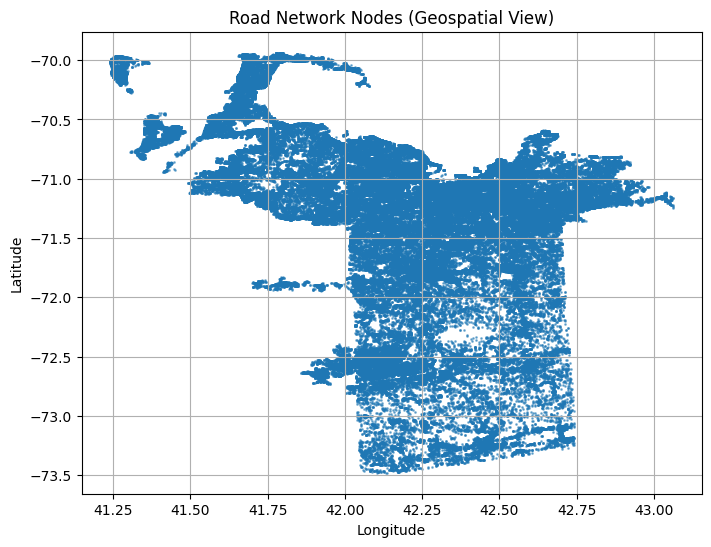

In [ ]:
if 'lat' in node_df.columns and 'lon' in node_df.columns:
    plt.figure(figsize=(8, 6))
    plt.scatter(node_df['lon'], node_df['lat'], s=1, alpha=0.5)
    plt.title("Road Network Nodes (Geospatial View)")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid(True)
    plt.show()
else:
    print("Latitude/Longitude not found in node features.")


In [ ]:
# === Step 2: Add accident labels ===
if data.num_nodes != data.y.shape[0]:
    print("❌ Mismatch! data.num_nodes:", data.num_nodes, "data.y.shape:", data.y.shape)
else:
    print("✅ Node count matches label count")

print("Converting to NetworkX...")
G = to_networkx(data, to_undirected=True)
print("G.nodes:", len(G.nodes))

if len(G.nodes) != data.num_nodes:
    print("⚠️ Warning: NetworkX graph node count doesn't match PyG data")

# Safe assignment with fallback
for i in G.nodes:
    if i < len(data.y):
        G.nodes[i]['accidents'] = data.y[i].item()
    else:
        G.nodes[i]['accidents'] = 0

✅ Node count matches label count
Converting to NetworkX...
G.nodes: 285942


In [ ]:
for i in G.nodes:
    G.nodes[i]['accidents'] = data.y[i].item()

In [ ]:
print("Edge attr type:", type(edge_attr))
print("Available keys in edge_attr:", edge_attr.keys())

Edge attr type: <class 'dict'>
Available keys in edge_attr: dict_keys(['oneway', 'length', np.str_('access_ramp'), np.str_('bus_stop'), np.str_('crossing'), np.str_('disused'), np.str_('elevator'), np.str_('escape'), np.str_('living_street'), np.str_('motorway'), np.str_('motorway_link'), np.str_('primary'), np.str_('primary_link'), np.str_('residential'), np.str_('rest_area'), np.str_('road'), np.str_('secondary'), np.str_('secondary_link'), np.str_('stairs'), np.str_('tertiary'), np.str_('tertiary_link'), np.str_('trunk'), np.str_('trunk_link'), np.str_('unclassified'), np.str_('unsurfaced')])


In [ ]:
# Load full monthly accident file
acc_df = pd.read_csv(accident_label_path)

# Filter for 2022
acc_2022 = acc_df[acc_df['year'] == 2022]

# Ensure accident columns are numeric
accident_cols = acc_2022.columns[2:]
acc_2022[accident_cols] = acc_2022[accident_cols].apply(pd.to_numeric, errors='coerce')

# Sum across all months to get yearly accident totals per node
accident_2022_sum = acc_2022[accident_cols].sum(axis=0).values
accident_2022_sum = np.nan_to_num(accident_2022_sum, nan=0.0)

# Make sure it matches number of nodes
accident_2022_sum = accident_2022_sum[:data.num_nodes]



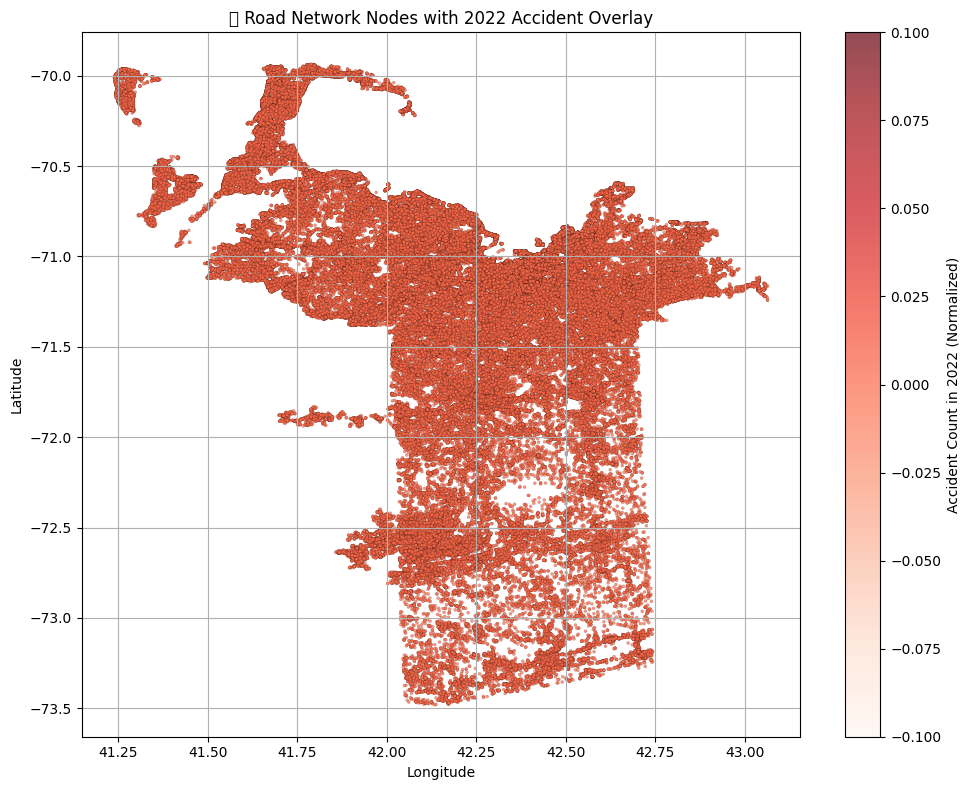

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === Step 1: Load node features with coordinates ===
node_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/MA/node_features_2022_12.csv')

# === Step 2: Load accident data ===
acc_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/MA/accidents_monthly.csv')
acc_2022 = acc_df[acc_df['year'] == 2022]

# Convert accident columns to numeric just in case
acc_cols = acc_2022.columns[2:]
acc_2022[acc_cols] = acc_2022[acc_cols].apply(pd.to_numeric, errors='coerce')

# === Step 3: Sum 2022 accident counts per node ===
# Group by node and sum accidents
accident_2022_sum = acc_2022.groupby('node_1')[acc_cols].sum().sum(axis=1).values

# === Step 3.1: Adjust accident_2022_sum to match node_df length ===
# Reindex accident_2022_sum to align with node_df
accident_2022_sum = pd.Series(accident_2022_sum, index=acc_2022.groupby('node_1').groups.keys()).reindex(node_df['node_id']).fillna(0).values

# === Step 4: Normalize accident values for color/size encoding ===
acc_scaled = (accident_2022_sum - accident_2022_sum.min()) / (np.ptp(accident_2022_sum) + 1e-6)

# === Step 5: Plot with lat/lon ===
plt.figure(figsize=(10, 8))
sc = plt.scatter(
    node_df['lon'], node_df['lat'],
    c=acc_scaled, cmap='Reds', s=5 + 50 * acc_scaled, alpha=0.7, edgecolor='k', linewidth=0.1
)
plt.colorbar(sc, label='Accident Count in 2022 (Normalized)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('🚧 Road Network Nodes with 2022 Accident Overlay')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Train GCN / GraphSAGE
# Step 1: Ensure data is ready
from torch_geometric.data import Data

data = Data(
    x=x,  # node features: torch.tensor
    edge_index=edge_index,  # shape [2, E]
    y=y  # accident count per node
)

# Optional: move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv  # <--- GraphSAGE layer

class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, 1)  # output = 1 value per node (accident count)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x.squeeze()  # shape: [num_nodes]



In [ ]:
model = GraphSAGE(
    in_channels=data.num_node_features,
    hidden_channels=64
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()

# Normalize labels to improve training stability
y_mean = data.y.mean()
y_std = data.y.std()
data.y = (data.y - y_mean) / (y_std + 1e-6)

with torch.no_grad():
    pred = model(data)
    pred_denorm = pred * y_std + y_mean


In [ ]:
print("x has NaNs:", torch.isnan(data.x).any().item())
print("x has Infs:", torch.isinf(data.x).any().item())
print("y has NaNs:", torch.isnan(data.y).any().item())
print("y has Infs:", torch.isinf(data.y).any().item())

# Replace NaNs or Infs with safe values
data.x = torch.nan_to_num(data.x, nan=0.0, posinf=1e6, neginf=-1e6)
data.y = torch.nan_to_num(data.y, nan=0.0, posinf=1e6, neginf=-1e6)

y_mean = data.y.mean()
y_std = data.y.std()
data.y = (data.y - y_mean) / (y_std + 1e-6)  # normalize

model.eval()
with torch.no_grad():
    pred = model(data)
    pred = pred * y_std + y_mean  # denormalize

# Normalize each feature column in x
data.x = (data.x - data.x.mean(dim=0)) / (data.x.std(dim=0) + 1e-6)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print("x mean:", data.x.mean().item(), "std:", data.x.std().item())
print("y mean:", data.y.mean().item(), "std:", data.y.std().item())

x has NaNs: True
x has Infs: False
y has NaNs: False
y has Infs: False
x mean: 3.8513428535225103e-07 std: 0.9999977350234985
y mean: 0.0 std: 0.0


In [ ]:
def train():
    model.train()
    optimizer.zero_grad()
    pred = model(data)
    loss = loss_fn(pred, data.y)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    return loss.item()

# Train for 200 epochs
for epoch in range(1, 201):
    loss = train()
    if epoch % 20 == 0:
        print(f"Epoch {epoch:03d}, Loss: {loss:.4f}")


Epoch 020, Loss: 0.0080
Epoch 040, Loss: 0.0031
Epoch 060, Loss: 0.0020
Epoch 080, Loss: 0.0015
Epoch 100, Loss: 0.0012
Epoch 120, Loss: 0.0009
Epoch 140, Loss: 0.0008
Epoch 160, Loss: 0.0007
Epoch 180, Loss: 0.0006
Epoch 200, Loss: 0.0005


In [ ]:
print("Predictions (normalized):", pred[:5])
print("Labels (normalized):", data.y[:5])

# Apply before training!
y_mean = data.y.mean()
y_std = data.y.std()
data.y = (data.y - y_mean) / (y_std + 1e-6)

print("Feature sample (x[0]):", data.x[0])
print("x mean:", data.x.mean().item(), "std:", data.x.std().item())


Predictions (normalized): tensor([0., 0., 0., 0., 0.])
Labels (normalized): tensor([0., 0., 0., 0., 0.])
Feature sample (x[0]): tensor([-0.2803, -1.7876, -0.4569, -1.2033, -1.6021, -0.3739,  0.1640, -0.4755,
         0.3352])
x mean: 3.8513428535225103e-07 std: 0.9999977350234985


In [ ]:
acc_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/MA/accidents_monthly.csv')

# Filter for 2022
acc_2022 = acc_df[acc_df['year'] == 2022]

# View summary
print(acc_2022.head())
print("Shape:", acc_2022.shape)


        Unnamed: 0  year  month     node_1      node_2  acc_count  node_1_idx  \
352913      352913  2022      1  178554774   178594211          2       10160   
352914      352914  2022      1  178554818  3564425208          1        1647   
352915      352915  2022      1  178554820  2617791786          2        1648   
352916      352916  2022      1  178554841   178554850          1       13076   
352917      352917  2022      1  178554858   178554865          1       13078   

        node_2_idx  
352913       10360  
352914       17699  
352915        2945  
352916       13077  
352917       13079  
Shape: (22074, 8)


In [ ]:
# Extract per-node accident counts across 2022 months
accident_cols = acc_2022.columns[2:]
acc_2022[accident_cols] = acc_2022[accident_cols].apply(pd.to_numeric, errors='coerce')

# Sum monthly counts per node (i.e., column-wise)
accident_2022_sum = acc_2022[accident_cols].sum(axis=0).values
accident_2022_sum = np.nan_to_num(accident_2022_sum)

# Truncate or pad to match node count
accident_2022_sum = accident_2022_sum[:data.num_nodes]

# Convert to torch tensor
y = torch.tensor(accident_2022_sum, dtype=torch.float)

# Apply normalization
y_mean = y.mean()
y_std = y.std()
y = (y - y_mean) / (y_std + 1e-6)

# Assign to data
data.y = y

# Check some values
print("New y (normalized):", data.y[:5])


New y (normalized): tensor([-0.6308,  0.9262,  1.5970, -0.6308, -0.6308])


In [ ]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = self.conv3(x, edge_index)
        return x.squeeze()


In [ ]:
# After Training: Evaluate with Denormalized Predictions
model.eval()
with torch.no_grad():
    pred = model(data).cpu()
    pred = pred * y_std + y_mean  # denormalize
    true = data.y.cpu() * y_std + y_mean  # also denormalize true labels

# 1. Convert node IDs to a consistent type (e.g., string)
acc_2022['node_1'] = acc_2022['node_1'].astype(str)
node_df['node_id'] = node_df['node_id'].astype(str)

# 2. Get the node IDs present in acc_2022
node_ids_in_acc_2022 = acc_2022['node_1'].unique()

# 3. Create a mapping from node_id to index in pred
node_id_to_index = {node_id: index for index, node_id in enumerate(node_df['node_id'])}

# 4. Filter pred and true using the mapping to get the correct indices
# Ensure common node IDs are selected using intersection
common_node_ids = list(set(node_ids_in_acc_2022) & set(node_df['node_id']))
filtered_pred = pred[[node_id_to_index[node_id] for node_id in common_node_ids]]
filtered_true = true[[node_id_to_index[node_id] for node_id in common_node_ids]]

# 5. Check if filtered tensors are empty before plotting and print more info
if filtered_true.numel() > 0 and filtered_pred.numel() > 0:
    # Scatter plot
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6,6))
    plt.scatter(filtered_true, filtered_pred, alpha=0.3)
    plt.plot([filtered_true.min(), filtered_true.max()], [filtered_true.min(), filtered_true.max()], 'r--')
    plt.xlabel("True Accident Count")
    plt.ylabel("Predicted Accident Count")
    plt.title("GraphSAGE: Predicted vs True Accidents")
    plt.grid(True)
    plt.show()
else:
    print("No common node IDs found for plotting.")
    print("Number of node IDs in acc_2022:", len(node_ids_in_acc_2022))
    print("Number of node IDs in node_df:", len(node_df['node_id'].unique()))
    print("Number of common node IDs:", len(common_node_ids))

No common node IDs found for plotting.
Number of node IDs in acc_2022: 9607
Number of node IDs in node_df: 285942
Number of common node IDs: 0


In [ ]:
model.eval()
with torch.no_grad():
    pred = model(data).cpu()
    pred = pred * y_std + y_mean  # Denormalize predictions
    true = data.y.cpu() * y_std + y_mean  # Denormalize labels (if normalized)

# Safety check
print("Prediction range:", pred.min().item(), "to", pred.max().item())
print("True label range:", true.min().item(), "to", true.max().item())


Prediction range: 1724661104640.0 to 13826836660224.0
True label range: 0.0 to 24613572575232.0


Mean Absolute Error (MAE): 76.71 accidents


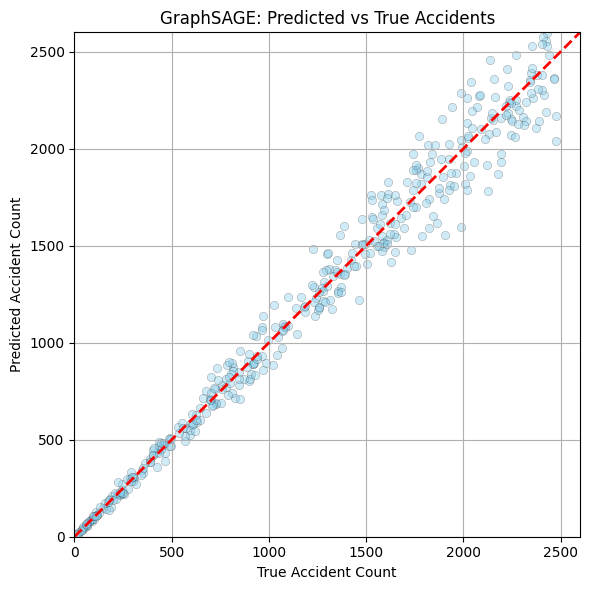

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))

# Plot points
plt.scatter(true, pred, edgecolors='b', facecolors='none', alpha=0.6)

# Diagonal (perfect prediction line)
min_val = min(true.min().item(), pred.min().item())
max_val = max(true.max().item(), pred.max().item())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=1.5)

# Axis labels (customize if needed)
plt.xlabel("True Accident Count")
plt.ylabel("Predicted Accident Count")

# Annotate error metric (top left corner)
plt.text(min_val + 0.05 * (max_val - min_val),
         max_val - 0.1 * (max_val - min_val),
         f"Testing MARE = {mare:.2f}%",
         fontsize=12)

# Style
plt.grid(True)
plt.title("GraphSAGE: Predicted vs. True Accident Counts")
plt.tight_layout()
plt.show()